In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [123]:
def load_raw_data(txt_filename: str) -> pd.DataFrame:
    """ Loads the .txt data from the Data folder as pandas DataFrame 
        :argument: txt_filename - name of the text file with .txt extension
        :return: dataframe - pandas DataFrame
    """
    # Define the data folder path
    data_path = Path().absolute().parent.joinpath('data', 'raw')
    # Open with pandas without header and space as separator
    dataframe = pd.read_csv(data_path.joinpath(txt_filename), sep=' ', header=None).dropna(axis=1, how='all')
    # Define number of sensor columns
    sensors_number = len(dataframe.columns) - 5
    # Rename the columns to corrensponding value
    column_names = ['unit', 'cycle', 'altitude', 'mach', 'tra'] + [f'sensor_{i}' for i in range(1, sensors_number + 1)]
    dataframe.columns = column_names
    return dataframe

def create_target(raw_data: pd.DataFrame) -> pd.DataFrame:
    """ Creates the RUL target variable based on max cycles from the dataset 
        :argument: raw_data - Pandas DataFrame containing training data
        :return: dataset - Pandas DataFrame containing training data and target variable
    """
    data = raw_data.copy()
    # Group the data by unit column and calculate the max cycle
    grouped = data.groupby('unit')
    max_cycle = grouped['cycle'].max()
    # Merge the max cycle back to the data
    data = data.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    # Calculate difference between max cycle and current cycle, create RUL
    data['rul'] = data['max_cycle'] - data['cycle']
    # Drop the max cycle column
    data.drop('max_cycle', axis=1, inplace=True)
    return data

def round_conditions(data: pd.DataFrame) -> pd.DataFrame:
    """ Rounds the values of condition columns (altitude, mach, tra) """
    data['altitude'] = data['altitude'].round()
    data['mach'] = data['mach'].round(2)
    data['tra'] = data['tra'].round()
    # Concatenate all 3 conditions into 1
    data['condition'] = data['altitude'] + data['mach'] + data['tra']
    keys = data['condition'].unique()
    mapping = {k: v for k, v in zip(keys, range(1, len(keys) + 1))}
    data['condition'] = data['condition'].map(mapping)
    return data

def standardize(input_data: pd.DataFrame):
    """ Standardizes the sensor values based on condition to have same mean to be comparable """
    data = input_data.copy()
    sensors = [e for e in list(data.columns) if 'sensor_' in e]
    for condition in data['condition'].unique():
        for column in sensors:
            mean =  data.loc[data['condition'] == condition, column].mean()
            std = data.loc[data['condition'] == condition, column].std()
            data.loc[data['condition'] == condition,column] = data.loc[data['condition'] == condition, column].map(lambda x: (x - mean) / (std + 0.0000001))
    return data

def get_condition_stats(data: pd.DataFrame) -> pd.DataFrame:
    """ Computes the Mean and Std for every sensor based on certain condition """
    sensors = [e for e in list(data.columns) if 'sensor_' in e]
    means, stds, conditions = [], [], []
    sensor_names = []
    for condition in data['condition'].unique():
        for column in sensors:
            sensor_names.append(column)
            conditions.append(condition)
            means.append(data.loc[data['condition'] == condition, column].mean())
            stds.append(data.loc[data['condition'] == condition, column].std())
    stats = pd.DataFrame(list(zip(sensor_names, means, stds, conditions)), columns=['sensor_name','mean', 'std', 'condition'])
    return stats

# =========================================================================PLOTTING=============================================================================

def plot_histogram(data: pd.DataFrame, column: str, unit: str = None) -> None:
    """ Plots the histogram for specified column grouped by unit """
    if column == 'rul':
        data = data[['unit', column]].groupby('unit').max().reset_index()
        unit = None
    if unit:
        data = data[data['unit'] == unit]
    data[column].hist(bins=15, figsize=(10,6))
    plt.xlabel(column)
    plt.show()
    
def plot_sensors(input_data: pd.DataFrame, sensor_names: list, unit: str = None, condition: int = None) -> None:
    """ Plots the sensor values for given sensor name over the RUL """
    data = input_data.copy()
    if len(sensor_names) != 4:
        return "Specify 4 sensor names"
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    if unit and condition:
        data = data[(data['unit'] == unit) & (data['condition'] == condition)]
    elif unit and not condition:
        data = data[data['unit'] == unit]
    elif condition and not unit:
        data = data[data['condition'] == condition]
        max_unit = data['unit'].max()
        random_units = np.random.randint(1, max_unit, size=5)
        print('Random units: ', random_units)
    else:
        max_unit = data['unit'].max()
        random_units = np.random.randint(1, max_unit, size=5)
        print('Random units: ', random_units)
    for i in range(2):
        for j in range(2):
            k = 0
            if i == 1:
                k = 1 
            sensor_name = sensor_names[j+i+k]
            if unit is None:
                for unit_number in random_units.tolist():
                    axs[i,j].plot('rul', sensor_name, data=data[data['unit'] == unit_number])
            else:
                axs[i,j].plot('rul', sensor_name, data=data)
            axs[i,j].set_xlim(300, 0) 
            axs[i,j].set_ylabel(sensor_name)
            axs[i,j].set_xlabel('RUL')
            axs[i,j].set_title(sensor_name)
            axs[i,j].grid(True, linewidth=0.5)
    plt.show()
    
def plot_condition(data: pd.DataFrame, unit: int, cond_column: str) -> None:
    """ Plotting condition values in respect to the RUL (line chart) """
    plt.figure(figsize=(15,5))
    plt.plot('rul', cond_column, '-', data=data[data['unit'] == unit])
    plt.xlim(200,0)
    plt.ylabel(cond_column)
    plt.show()
    
def plot_condition_stats(conditioned_stats: pd.DataFrame, sensor: str) -> None:
    """ Plotting mean values of the specific sensor for all conditions """
    fig, ax1 = plt.subplots(figsize=(12,5))
    # First Y axis (Mean)
    color_1 = 'tab:blue'
    ax1.plot('condition', 'mean', 'o-', data=conditioned_stats[conditioned_stats['sensor_name'] == sensor], color=color_1)
    ax1.set_xlabel('Condition')
    ax1.set_ylabel('Mean', color=color_1)
    ax1.tick_params(axis='y', labelcolor=color_1)
    # Second Y axis (Std)
    ax2 = ax1.twinx() 
    color_2 = 'tab:red'
    ax2.plot('condition', 'std', 'o-', data=conditioned_stats[conditioned_stats['sensor_name'] == sensor], color=color_2)
    ax2.set_ylabel('Std', color=color_2) 
    ax2.tick_params(axis='y', labelcolor=color_2)
    fig.tight_layout() 
    plt.show()
    # Show stats
    print(conditioned_stats[conditioned_stats['sensor_name'] == sensor])

In [85]:
raw_data = load_raw_data('train_FD004.txt')
data = create_target(raw_data)
data = round_conditions(data)
standardized_data = standardize(data)
conditioned_stats = get_condition_stats(data)

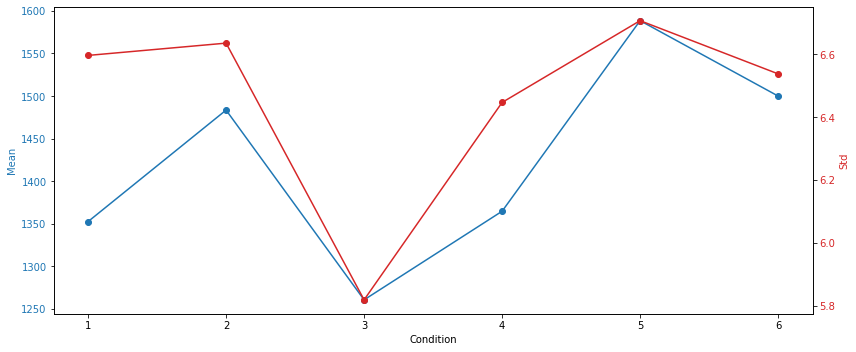

    sensor_name         mean       std  condition
2      sensor_3  1352.562715  6.596366          1
23     sensor_3  1483.501860  6.635482          2
44     sensor_3  1260.672766  5.818127          3
65     sensor_3  1364.709756  6.446601          4
86     sensor_3  1588.519059  6.707031          5
107    sensor_3  1500.003491  6.537669          6


In [124]:
plot_condition_stats(conditioned_stats, sensor='sensor_3')

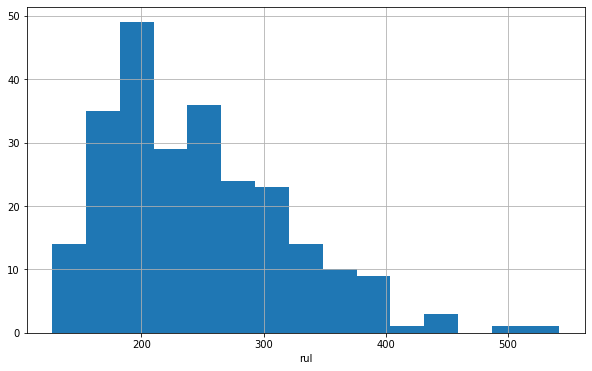

In [4]:
plot_histogram(data, 'rul')

Random units:  [115  58 231 103 100]


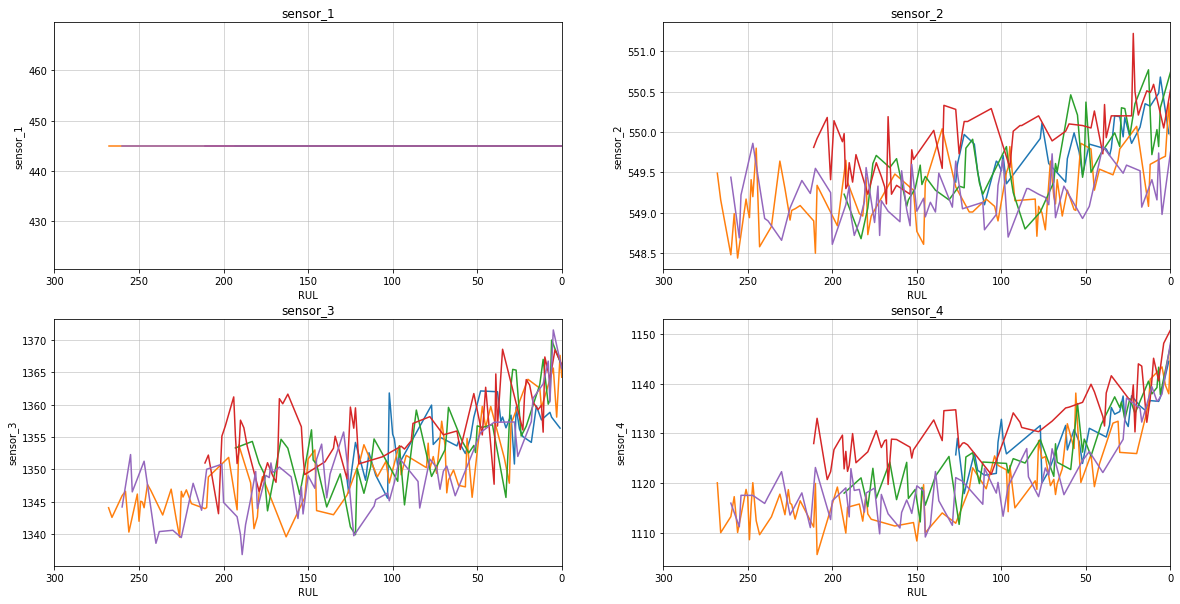

In [59]:
condition = 1
sensors = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']
plot_sensors(data, sensors, condition=condition)

Random units:  [ 38 180  23   8 113]


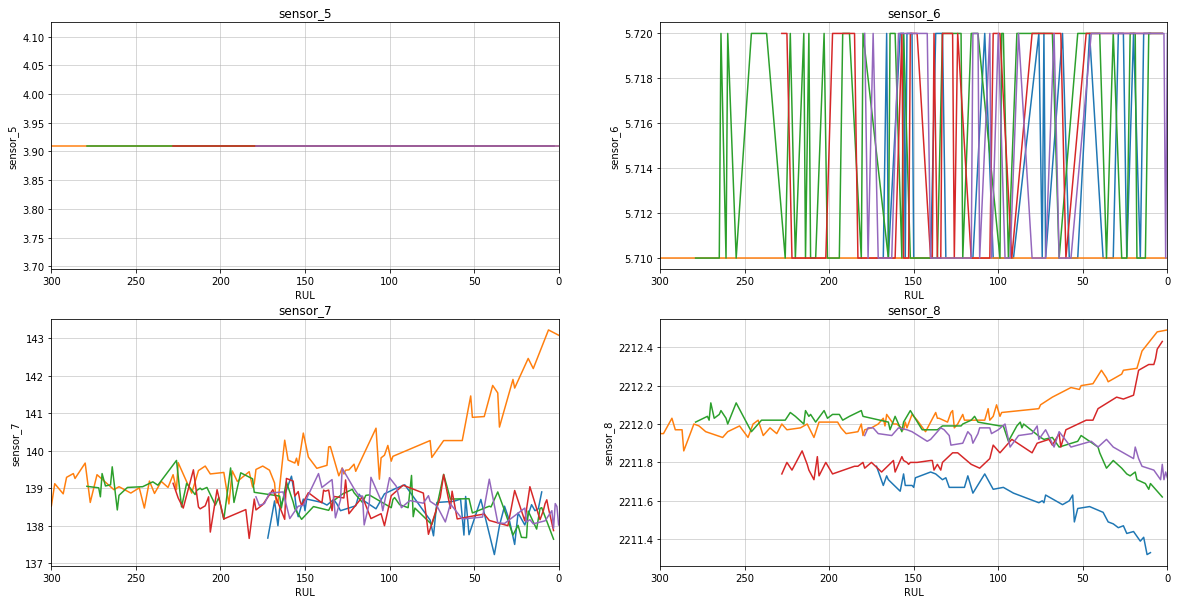

In [60]:
sensors = ['sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']
plot_sensors(data, sensors, condition=condition)

Random units:  [ 61 201  70 161 247]


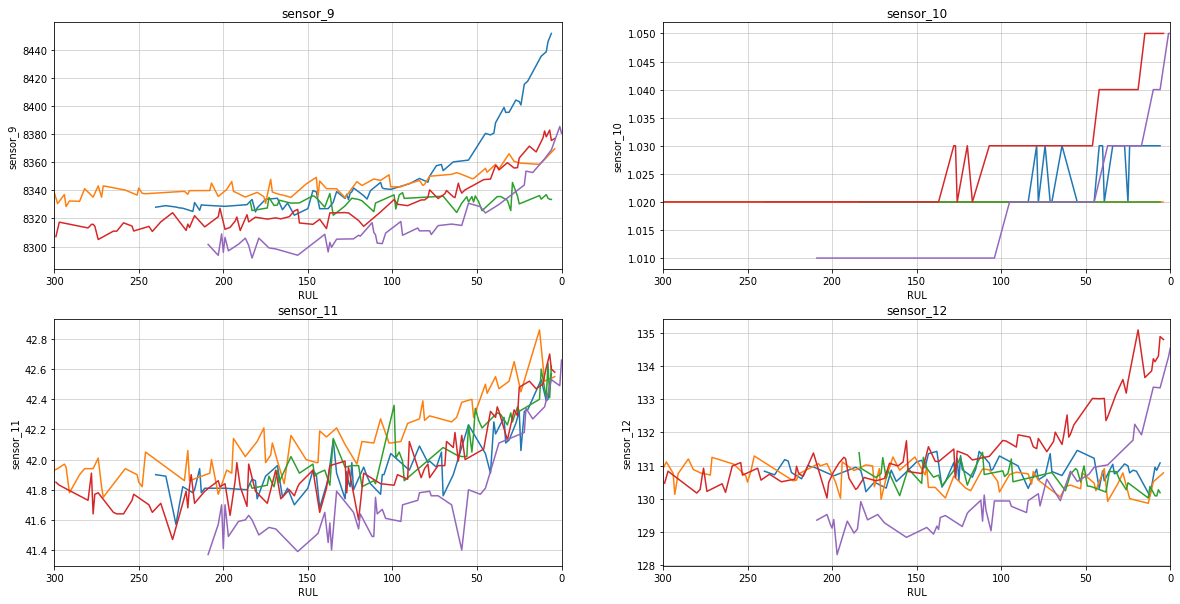

In [61]:
sensors = ['sensor_9', 'sensor_10', 'sensor_11', 'sensor_12']
plot_sensors(data, sensors, condition=condition)

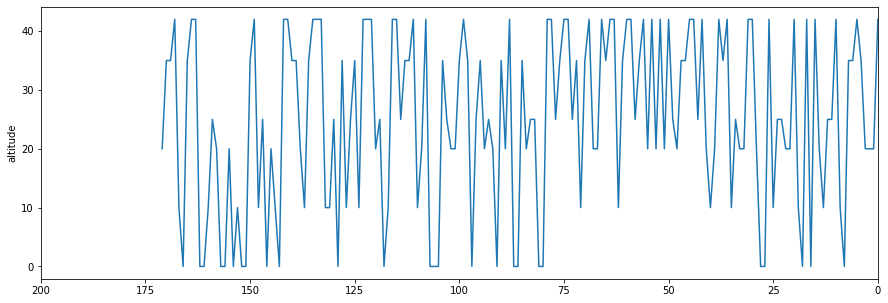

In [65]:
plot_condition(data, unit=50, cond_column='altitude')